# Exploratory Data Analysis in SQL and Python

Analyzing the San-Francisco Crime dataset Using SQL and Python for indepth analysis.<br>
We connect to MySQL server and workbench and make analysis with the crime_data database.

In [1]:
# we import some required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time
print('Done!')

Done!


In [2]:
import mysql
from mysql.connector import Error
from getpass import getpass

db_name = 'crime_data'
try:
    connection = mysql.connector.connect(host='localhost',
                                         database=db_name,
                                         user=input('Enter UserName:'),
                                         password=getpass('Enter Password:'))
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Enter UserName:danam
Enter Password:········
Connected to MySQL Server version  8.0.24
You're connected to database:  ('crime_data',)


In [3]:
def query_to_df(query):
    st = time.time()
    # Assert Every Query ends with a semi-colon
    try:
        assert query.endswith(';')
    except AssertionError:
        return 'ERROR: Query Must End with ;'

    # so we never have more than 50 rows displayed
    pd.set_option('display.max_rows', 30) 
    df = None

    # Process the query
    cursor.execute(query)
    columns = cursor.description
    result = []
    for value in cursor.fetchall():
        tmp = {}
        for (index,column) in enumerate(value):
            tmp[columns[index][0]] = [column]
        result.append(tmp)

    # Create a DataFrame from all results
    for ind, data in enumerate(result):
        if ind >= 1:
            x = pd.DataFrame(data)
            df = pd.concat([df, x], ignore_index=True)
        else:
            df = pd.DataFrame(data)
    print(f'Query ran for {time.time()-st} secs!')
    return df

In [4]:
# Let's see the tables in crime_data database

query_to_df(
'SHOW TABLES;'
)

Query ran for 0.1706554889678955 secs!


,Tables_in_crime_data
0,sf_crime_data


In [5]:
# For the sf_crime_data

query = 'SELECT * FROM sf_crime_data LIMIT 3;'
query_to_df(query)

Query ran for 0.14816808700561523 secs!


,id,incidnt_num,category,descript,day_of_week,dates,times,pd_district,resolution,address,lon,lat,location
0,1,140000000,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:00:00,INGLESIDE,NONE,0 Block of GARRISON AV,-122.413628,37.709724,"(37.709725805163, -122.413623946206)"
1,2,140000000,ASSAULT,BATTERY,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:45:00,TARAVAL,"ARREST, CITED",100 Block of FONT BL,-122.473709,37.715488,"(37.7154876086057, -122.47370623066)"
2,3,140000000,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,01/31/2014 08:00:00 AM +0000,0 days 15:30:00,PARK,NONE,0 Block of CASTRO ST,-122.435722,37.768688,"(37.7686887134351, -122.435718550322)"


Let's see how many crimes have been reported

In [6]:
query_to_df(
"SELECT COUNT(*) total_crimes FROM sf_crime_data;"
)

Query ran for 0.2767481803894043 secs!


,total_crimes
0,30400


Let's see the different categories of offences

In [7]:
query_to_df(
"SELECT DISTINCT category FROM sf_crime_data;"
)

Query ran for 0.05154275894165039 secs!


,category
0,VEHICLE THEFT
1,ASSAULT
2,SUSPICIOUS OCC
3,OTHER OFFENSES
4,DRUG/NARCOTIC
...,...
31,BRIBERY
32,BAD CHECKS
33,RECOVERED VEHICLE
34,GAMBLING


Ok, there are 36 different categories of reported offences, let's see what types of crimes occur generally, from most to least frequent

In [8]:
query_to_df(
"SELECT DISTINCT category, COUNT(*) num_crimes FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC;"
)

Query ran for 0.06881594657897949 secs!


,category,num_crimes
0,LARCENY/THEFT,8211
1,OTHER OFFENSES,3719
2,NON-CRIMINAL,3554
3,ASSAULT,2399
4,VANDALISM,1545
...,...,...
31,"SEX OFFENSES, NON FORCIBLE",6
32,BAD CHECKS,4
33,GAMBLING,4
34,STOLEN PROPERTY,3


Let's zoom in on the Top 10 categories. 

Query ran for 0.04092049598693848 secs!


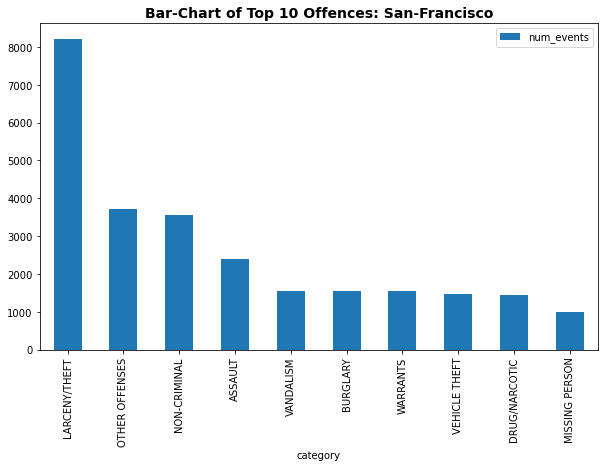

In [29]:
fdict = {'fontweight':'bold', 'fontsize':14}

(query_to_df(
"SELECT category, COUNT(*) num_events FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10;"
)).set_index('category').plot.bar(figsize=(10,6))
plt.title('Bar-Chart of Top 10 Offences: San-Francisco', fontdict=fdict)
plt.show()

What percentage of total offences do the Top 10 offences constitute?

In [19]:
query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) num_offences FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT SUM(num_offences) top_offences, (SUM(num_offences) / (SELECT COUNT(*) FROM sf_crime_data))*100 \
AS pct_top_offences FROM t1) \
SELECT * FROM t2;"
)

Query ran for 0.03789663314819336 secs!


,top_offences,pct_top_offences
0,26431,86.9441


So, the Top 10 categories of offences sum up to 26431 and contribute almost 87% of total offences reported.<br>Therefore for simplicity's sakes we shall focus on the distribution of these Top 10 offences.

We can see from the data that offences are recorded per district, in the variable `pd_district`. Let's see the unique districts from the data.

In [18]:
query_to_df(
"SELECT DISTINCT pd_district FROM sf_crime_data;"
)

Query ran for 0.025957822799682617 secs!


,pd_district
0,INGLESIDE
1,TARAVAL
2,PARK
3,CENTRAL
4,SOUTHERN
5,RICHMOND
6,BAYVIEW
7,MISSION
8,NORTHERN
9,TENDERLOIN


Now, let's write SQL query to extract the distribution of total Top-10-offences per district 

In [25]:
query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) count FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) num_top_offences FROM sf_crime_data WHERE category IN \
(SELECT category FROM t1) GROUP BY 1 ORDER BY 2 DESC) \
SELECT * FROM t2;"
)

Query ran for 0.0718071460723877 secs!


,pd_district,num_top_offences
0,SOUTHERN,5218
1,MISSION,3448
2,NORTHERN,3389
3,CENTRAL,2789
4,BAYVIEW,2432
5,INGLESIDE,2205
6,TENDERLOIN,2185
7,TARAVAL,1747
8,PARK,1520
9,RICHMOND,1498


Let's visualize the distribution, using a horizontal barchart.

Query ran for 0.06984663009643555 secs!


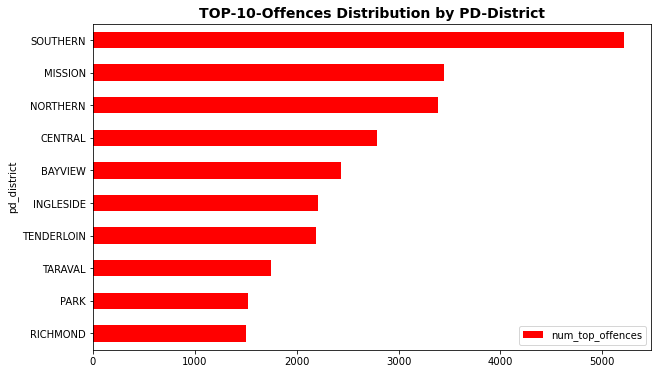

In [31]:
(query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) count FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) num_top_offences FROM sf_crime_data WHERE category IN \
(SELECT category FROM t1) GROUP BY 1 ORDER BY 2) \
SELECT * FROM t2;"
)).set_index('pd_district').plot(kind='barh', figsize=(10,6), color='red')
plt.title('TOP-10-Offences Distribution by PD-District', fontdict=fdict)
plt.show()

Out of these 10 Districts, the Southern District has over twice the number of reported offences as 6 other districts: (`Bayview`, `Ingleside`, `Tenderloin`, `Taraval`, `Park`, `Richmond`).<br>`Southern`, `Mission` and `Northern` Districts are the Top 3 in terms of reported offences. While `Richmond` is lowest on reported offences.

From the `resolution` variable in the dataset, we can see that not all offences have been resolved in various Districts.<br>Let's investigate further District-wise. 

First, let's see the distribution of distinct explanation phrases used to describe resolution

In [34]:
query_to_df(
"SELECT DISTINCT resolution, COUNT(*) num_offences FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC;"
)

Query ran for 0.07567954063415527 secs!


,resolution,num_offences
0,NONE,18927
1,"ARREST, BOOKED",6505
2,"ARREST, CITED",2509
3,PSYCHOPATHIC CASE,1074
4,LOCATED,698
5,UNFOUNDED,170
6,JUVENILE BOOKED,147
7,COMPLAINANT REFUSES TO PROSECUTE,118
8,JUVENILE CITED,92
9,PROSECUTED BY OUTSIDE AGENCY,66


Some interesting findings here, almost `19000` out of `30400` cases are unresolved. That's about `62%` of cases. We also have `170` unfounded cases. These are offences that are simply not True or no evidence to support the reports. In some cases(`118`) the complainant refused to prosecute, that's really interesting, the reasons are as varied as we can imagine. Then there are about `9000` arrested and booked or cited cases and about `280` cases involving Juveniles.

Let's see the split of unresolved offences and offences inwhich arrests have been made per District.